In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool, cpu_count
import modin.pandas as mpd
import polars as pl
import time
from dotenv import load_dotenv
import os


In [2]:
df = pd.read_csv("temperature_data.csv")

In [3]:
df.head()

,city,timestamp,temperature,season
0,New York,2010-01-01,4.872807,winter
1,New York,2010-01-02,1.096591,winter
2,New York,2010-01-03,1.596375,winter
3,New York,2010-01-04,1.394252,winter
4,New York,2010-01-05,-5.374231,winter


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54750 entries, 0 to 54749
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         54750 non-null  object 
 1   timestamp    54750 non-null  object 
 2   temperature  54750 non-null  float64
 3   season       54750 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.7+ MB


In [5]:
df.describe()

,temperature
count,54750.000000
mean,18.320200
std,11.025819
min,-25.999236
25%,11.162345
50%,18.767123
75%,26.063238
max,55.135633


In [6]:
df.describe(include="object")

,city,timestamp,season
count,54750,54750,54750
unique,15,3650,4
top,New York,2010-01-01,spring
freq,3650,15,13800


In [7]:
df.isna().sum()

city           0
timestamp      0
temperature    0
season         0
dtype: int64

In [8]:
#Приведем "timestamp" и отсортируем по времени и город по алфавиту
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.sort_values(["city", "timestamp"]).reset_index(drop=True)

In [9]:
df.head()

,city,timestamp,temperature,season
0,Beijing,2010-01-01,-10.753087,winter
1,Beijing,2010-01-02,8.107699,winter
2,Beijing,2010-01-03,-3.939075,winter
3,Beijing,2010-01-04,-13.532031,winter
4,Beijing,2010-01-05,-4.618617,winter


In [10]:
#Посчитаем скользящее среднее по городам
df["ma30"] = df.groupby("city")["temperature"].transform(lambda ma: ma.rolling(window=30, min_periods=1).mean())


In [11]:
#Посчитаем сезонные статистики
season_statistics = df.groupby(["city", "season"])["temperature"].agg(season_mean="mean", season_std="std", n="count").reset_index()
df = df.merge(season_statistics, on=["city", "season"], how="left")

In [12]:
season_statistics.head()

,city,season,season_mean,season_std,n
0,Beijing,autumn,16.135716,5.253118,910
1,Beijing,spring,13.015708,5.030016,920
2,Beijing,summer,27.103416,5.190959,920
3,Beijing,winter,-1.950839,4.919879,900
4,Berlin,autumn,10.964937,5.002362,910


In [13]:
#Выявим аномалии, где температура выходит за пределы  среднее±2𝜎
df["lower_bound"] = df["season_mean"] - 2 * df["season_std"]
df["upper_bound"] = df["season_mean"] + 2 * df["season_std"]
df["is_anomaly"] = (df["temperature"] < df["lower_bound"]) | (df["temperature"] > df["upper_bound"])

In [14]:
df.head()

,city,timestamp,temperature,season,ma30,season_mean,season_std,n,lower_bound,upper_bound,is_anomaly
0,Beijing,2010-01-01,-10.753087,winter,-10.753087,-1.950839,4.919879,900,-11.790598,7.88892,False
1,Beijing,2010-01-02,8.107699,winter,-1.322694,-1.950839,4.919879,900,-11.790598,7.88892,True
2,Beijing,2010-01-03,-3.939075,winter,-2.194821,-1.950839,4.919879,900,-11.790598,7.88892,False
3,Beijing,2010-01-04,-13.532031,winter,-5.029124,-1.950839,4.919879,900,-11.790598,7.88892,True
4,Beijing,2010-01-05,-4.618617,winter,-4.947022,-1.950839,4.919879,900,-11.790598,7.88892,False


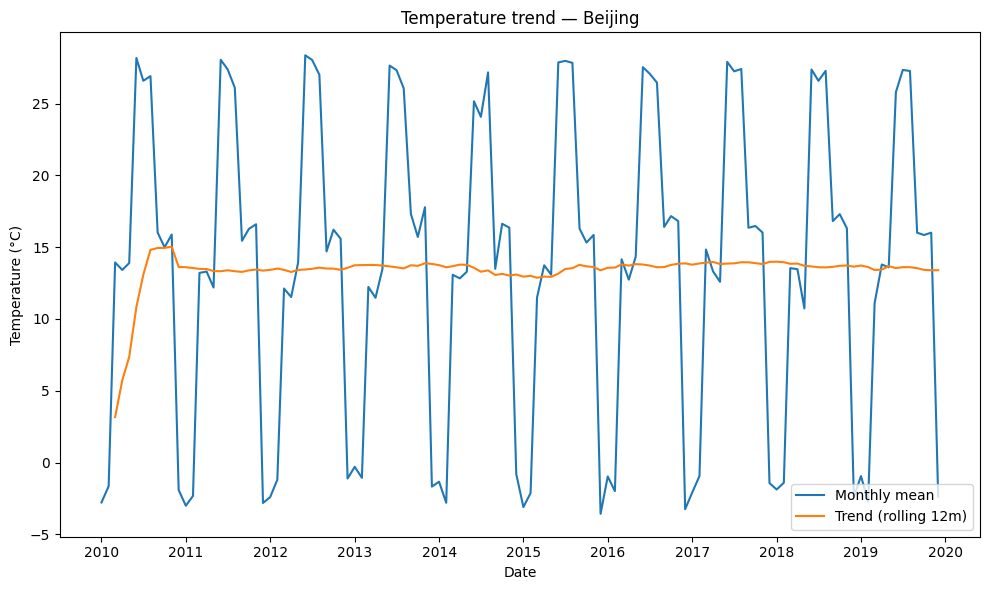

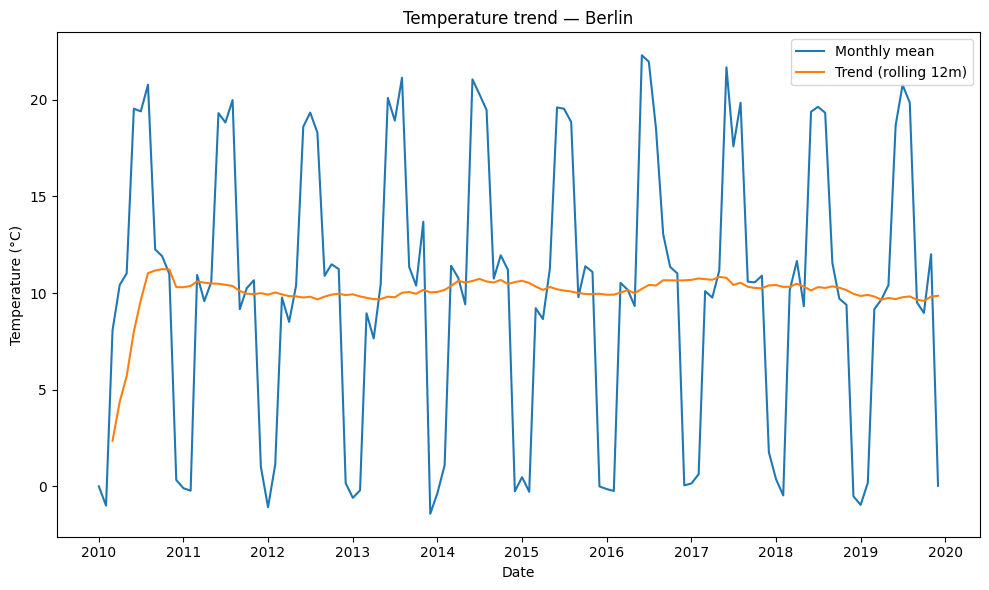

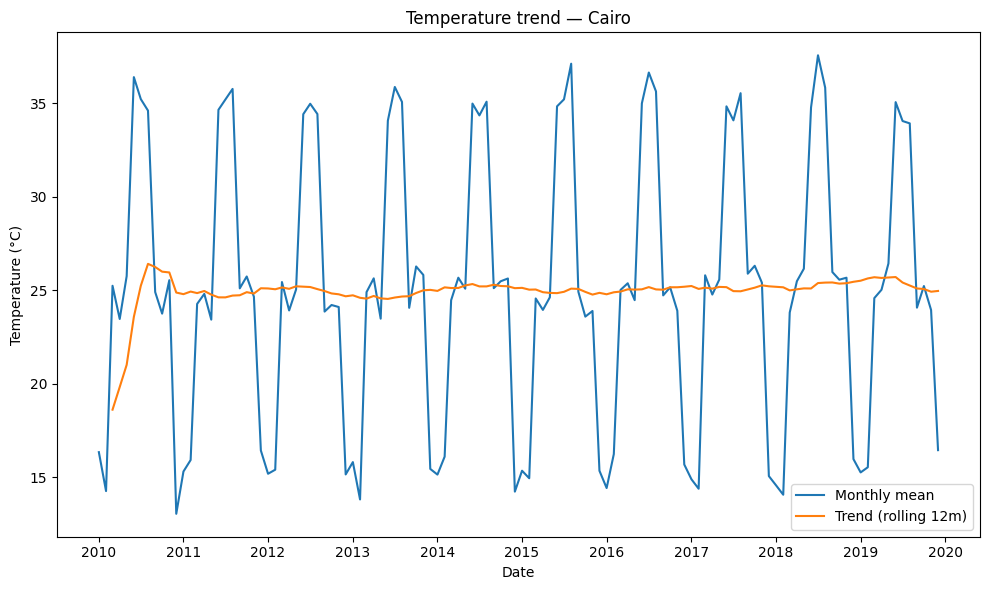

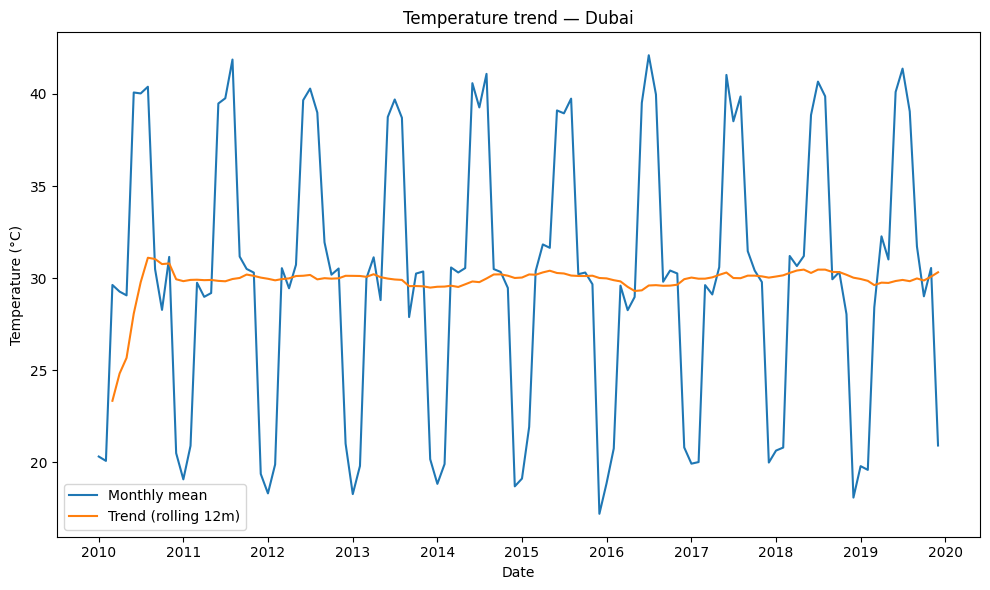

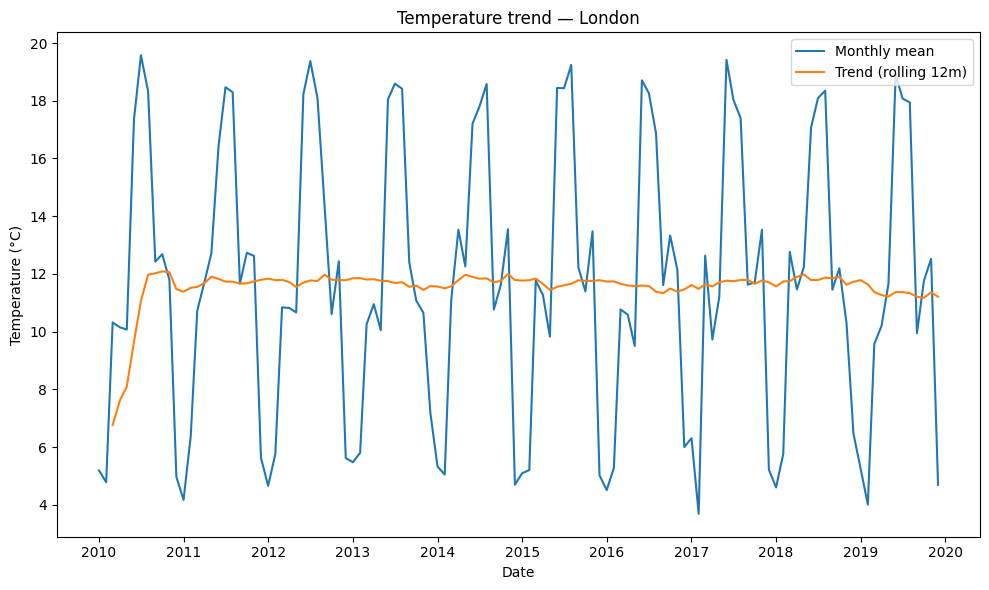

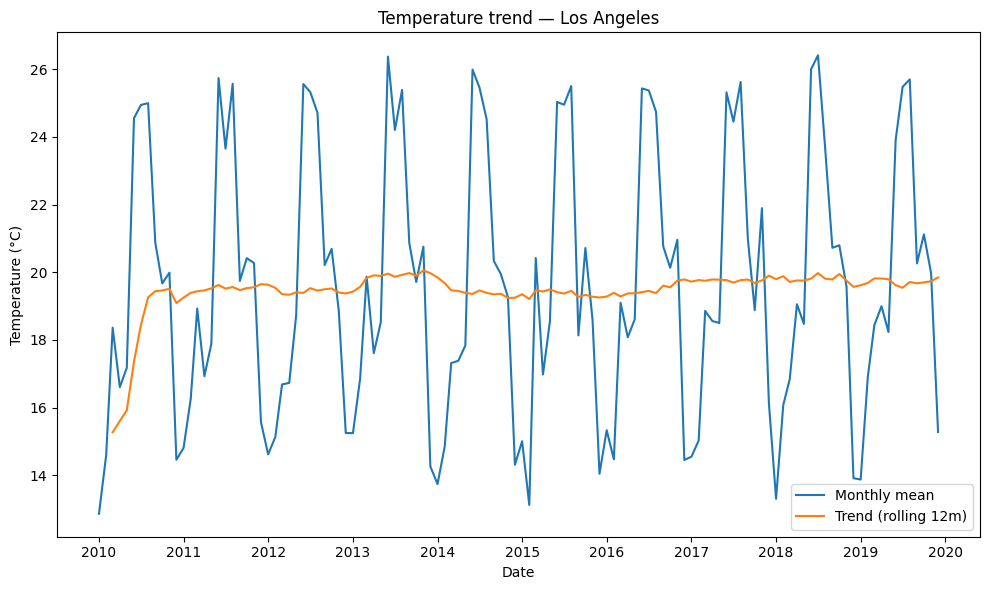

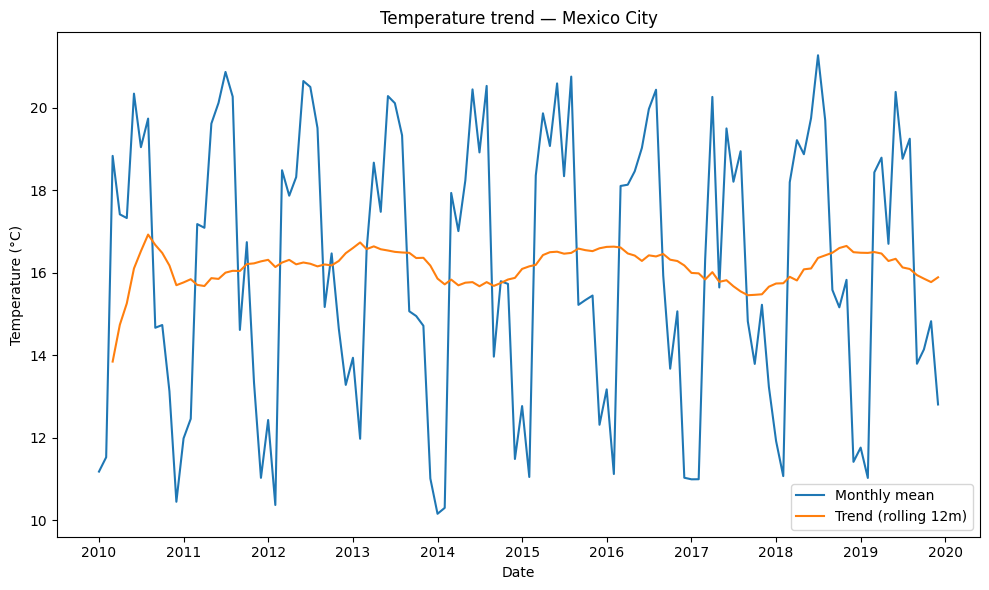

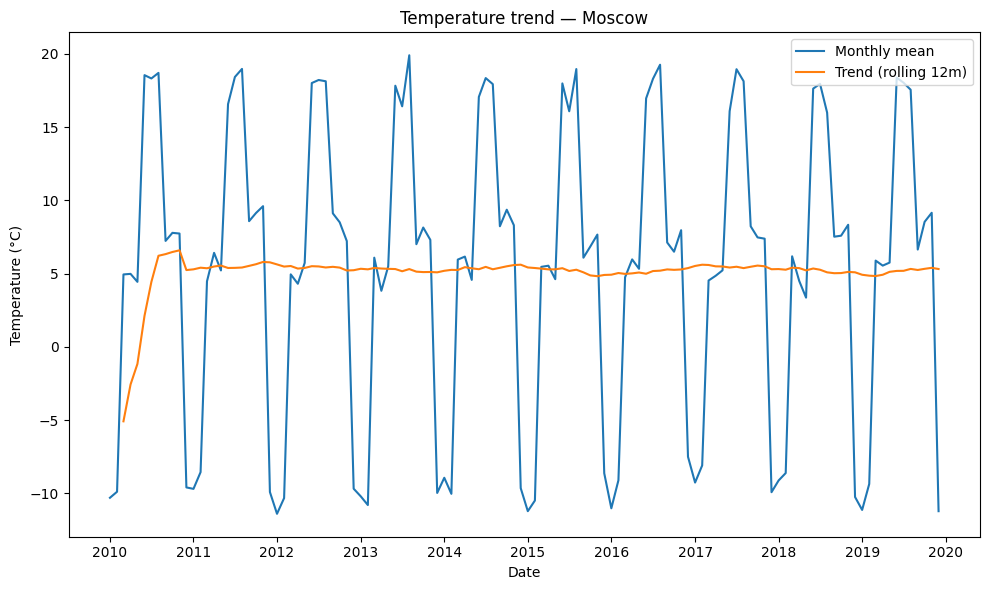

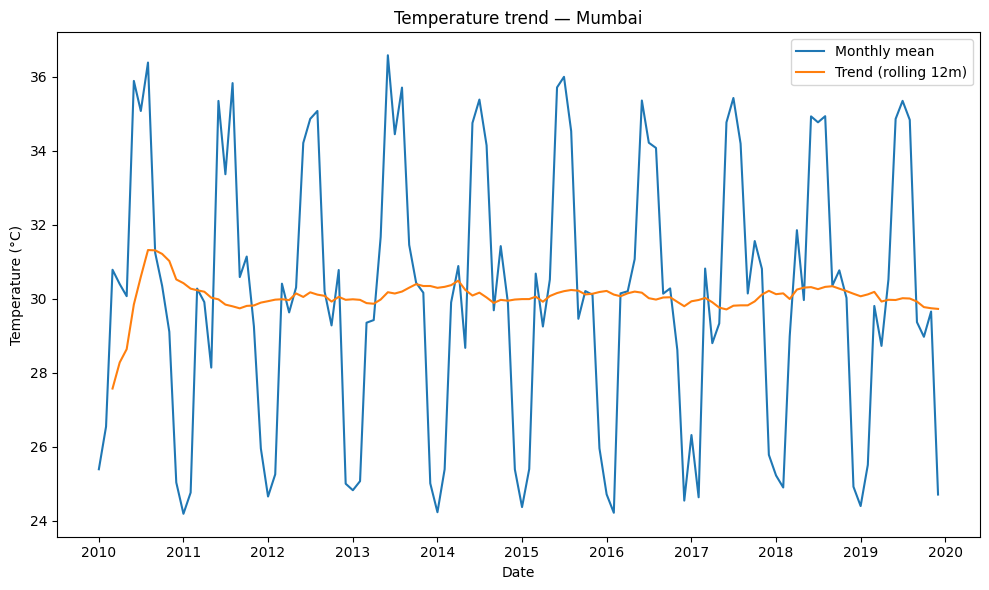

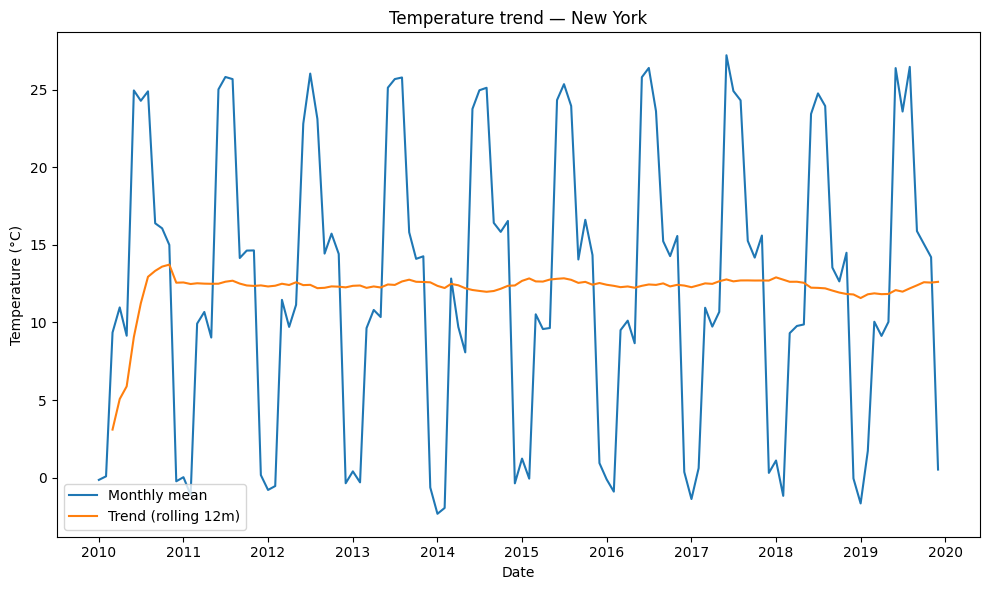

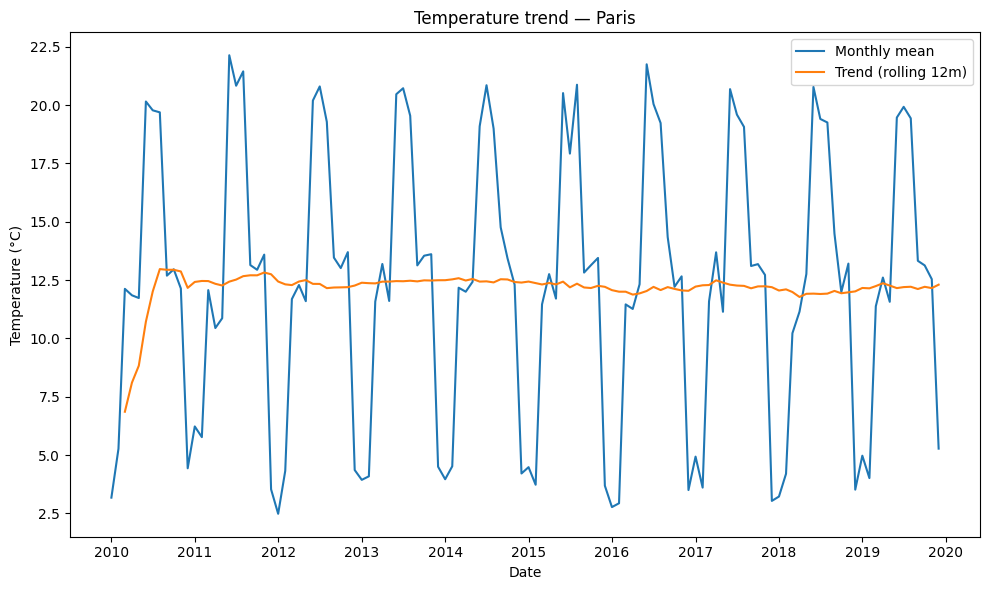

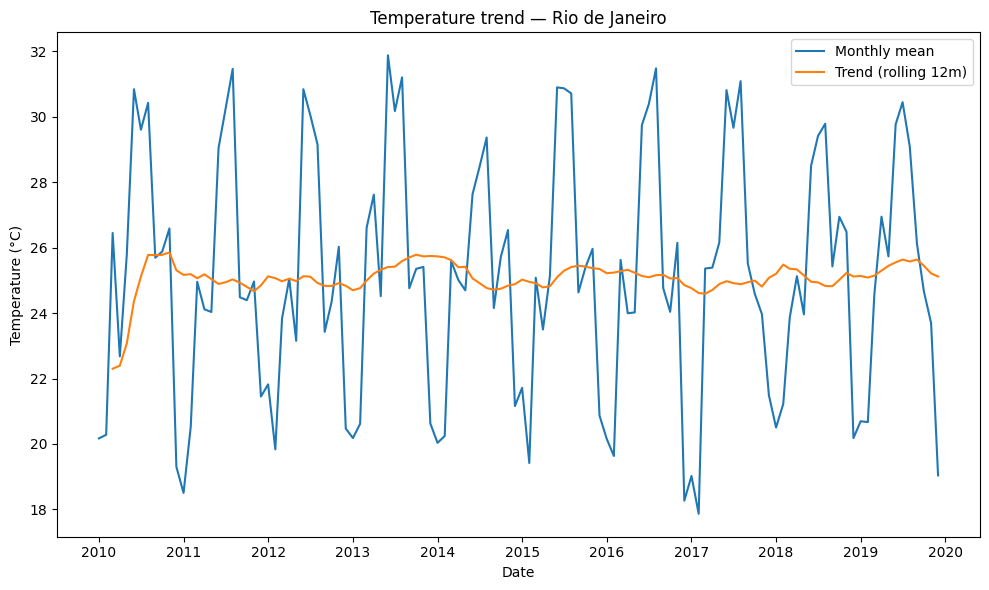

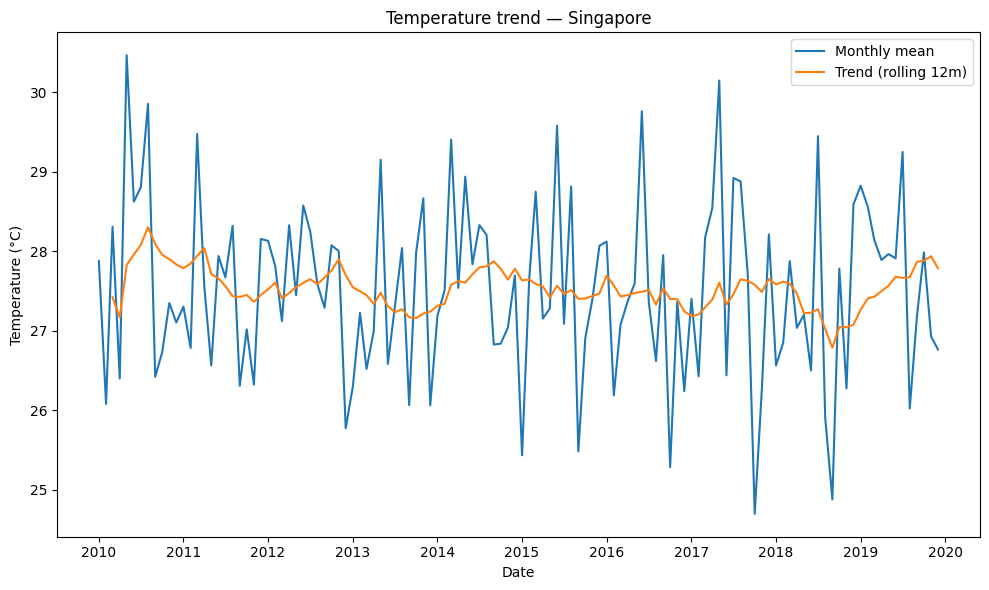

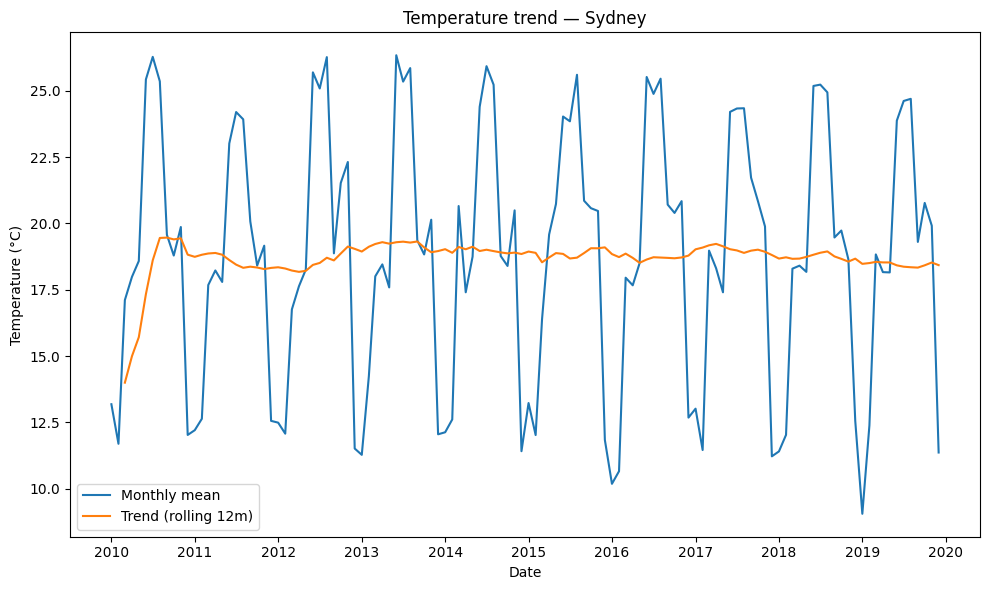

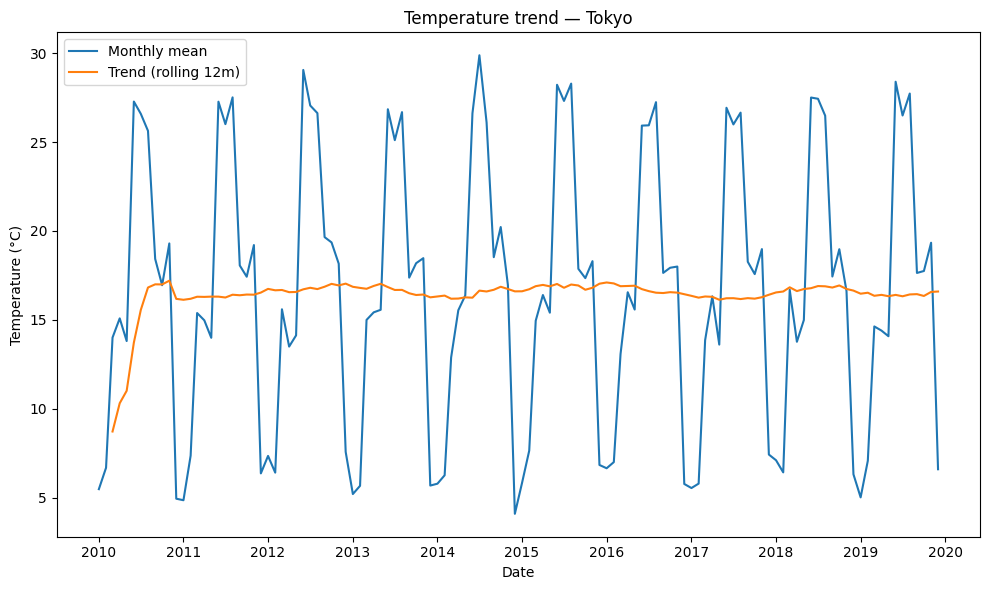

In [15]:
#Построение долгосрочных трендов изменения температуры (по месячным средним)
monthly = (
    df.set_index("timestamp")
      .groupby("city")["temperature"]
      .resample("MS")
      .mean()
      .reset_index()
      .rename(columns={"temperature": "temp_month_mean"})
)

#Сглаживание тренда
monthly["trend_12m"] = (
    monthly.sort_values(["city", "timestamp"])
           .groupby("city")["temp_month_mean"]
           .transform(lambda s: s.rolling(12, min_periods=3).mean())
)

city_names = df["city"].unique()

for city in city_names:
    g = monthly[monthly["city"] == city].sort_values("timestamp")

    plt.figure(figsize=(10, 6))
    plt.plot(g["timestamp"], g["temp_month_mean"], label="Monthly mean")
    plt.plot(g["timestamp"], g["trend_12m"], label="Trend (rolling 12m)")
    plt.title(f"Temperature trend — {city}")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

### Попробуем распараллелить данный анализ с помощью подходов:
1. __pandas с многопроцессностью (multiprocessing)__

Использует стандартный pandas, распараллеливая операции по строкам или столбцам с помощью multiprocessing.

2. __modin__

Альтернатива pandas, автоматически распараллеливающая операции с использованием Ray или Dask.

3. __polars__

Высокопроизводительная библиотека для обработки данных с помощью многопоточности и оптимизаций на уровне алгоритмов.

Выполнено в файле __parallel_EDA.py__

### __Результаты:__

| Подход                       |  Median (s) | Min (s) | Max (s) | Относительно default pandas |
| ---------------------------- | ----------: | ------: | ------: | --------------------------: |
| **default pandas**           |  **0.0217** |  0.0214 |  0.0256 |                        1.0× |
| **pandas + multiprocessing** | **15.2892** | 13.5134 | 17.9041 |         **~704× медленнее** |
| **modin**                    |  **0.5877** |  0.5280 |  0.6149 |          **~27× медленнее** |
| **polars**                   |  **0.0080** |  0.0071 |  0.0179 |           **~2.7× быстрее** |


| Метод                  | median (s) | min (s) | max (s) | runs (s)                               |
| ---------------------- | ---------: | ------: | ------: | -------------------------------------- |
| pandas (default)       |     0.0211 |  0.0203 |  0.0309 | 0.0309, 0.0211, 0.0210, 0.0220, 0.0203 |
| pandas multiprocessing |     1.0932 |  1.0892 |  1.1659 | 1.1659, 1.0932, 1.0904, 1.0892, 1.1094 |
| modin                  |     1.0463 |  0.9935 |  3.4515 | 3.4515, 0.9935, 1.0463, 1.0344, 1.1991 |
| polars                 |     0.0078 |  0.0073 |  0.1285 | 0.1285, 0.0078, 0.0073, 0.0073, 0.0090                                      |


### __Выводы:__

На наших данных достаточно использовать стандартный `pandas`, который показал высокую эффективность и оказался быстрее некоторых параллельных подходов за счёт отсутствия временных расходов для параллельности. 

Использование `multiprocessing` с pandas привело к резкому ухудшению производительности из-за затрат на создание процессов и управление процессами. 

`Modin` на `Ray` не дал выигрыша по времени, так как накладные расходы на планирование вычислений превышают пользу от параллелизма на небольших данных. 

Наилучший результат продемонстрировал `Polars`, обеспечив максимальную скорость и стабильность благодаря встроенной многопоточности и оптимизированной обработке данных.



In [ ]:
Время работы синхронного варианта: 1.5210904580308124
Время работы aсинхронного варианта: 0.20676158397691324